## Семинар 2 "Распознавание рукописных цифр"

ФИО: Гасанов Марат Шамильевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork
# from dz1 import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

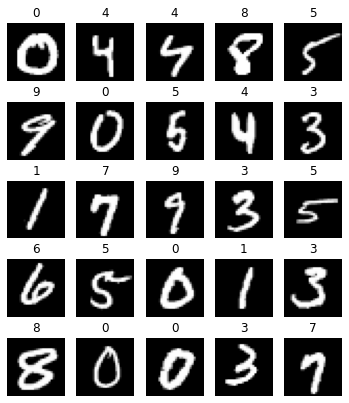

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
layers = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn = NeuralNetwork(layers)
loss = NLLLoss()

In [7]:
from tqdm import tqdm_notebook

In [18]:
def fit(nn, loss, train_loader, test_loader, n_epoch=50, learning_rate=0.01, plot=True):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    for i in tqdm_notebook(range(n_epoch)):
        curr_losses = []
        curr_accuracies_train = []
        curr_losses_test = []
        curr_accuracies_test = []
        for X, y in train_loader:
            X = X.view(X.shape[0], -1).numpy()
            y = y.numpy()
            pred = nn.forward(X)
            loss_ = loss.forward(pred, y).sum()
            nn.backward(loss.backward())
            nn.step(learning_rate=learning_rate)
            curr_losses.append(loss_)
            curr_accuracies_train.append((np.argmax(pred, 1)==y).mean())
        train_losses.append(np.mean(curr_losses))
        train_accuracies.append(np.mean(curr_accuracies_train))
        for X_test, y_test in test_loader:
            X_test = X_test.view(X_test.shape[0], -1).numpy()
            y_test = y_test.numpy()
            pred = nn.forward(X_test)
            loss_ = loss.forward(pred, y_test).sum()
            curr_losses_test.append(loss_)
            curr_accuracies_test.append((np.argmax(pred, 1)==y_test).mean())
        test_losses.append(np.mean(curr_losses_test))
        test_accuracies.append(np.mean(curr_accuracies_test))

    if plot:
        plt.plot(train_losses, label='train')
        plt.plot(test_losses, color='g', label='test')
        plt.title("loss")
        plt.grid('on')
        plt.legend(fontsize=16)
        plt.show()
        plt.plot(train_accuracies, label='train')
        plt.plot(test_accuracies, color='g', label='test')
        plt.title("accuracies")
        plt.grid('on')
        plt.legend(fontsize=16)
        plt.show()
    return train_losses, test_losses, train_accuracies, test_accuracies

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

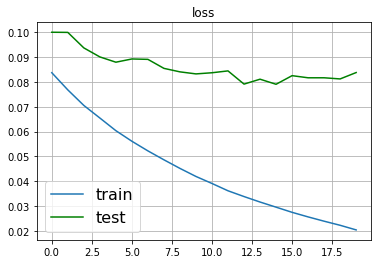

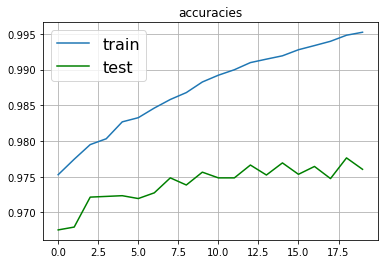

Final loss train is 0.020426038526727128,
Final loss test is 0.08372650834412756


In [19]:
train_sigmoid_losses, test_sigmoid_losses, train_sigmoid_accuracies, test_sigmoid_accuracies = fit(nn=nn, loss=loss, learning_rate=0.01, n_epoch=20, train_loader=train_loader, test_loader=test_loader)
print("Final loss train is {},\nFinal loss test is {}".format(train_sigmoid_losses[-1], test_sigmoid_losses[-1]))

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [20]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.y = np.maximum(0, X)
        self.X = X
        return self.y

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        # print("X dim " + str(self.X.shape))
        # print("Y dim " + str(self.y.shape))
        # print("dLdy dim " + str(dLdy.shape))
        return (self.X > 0) * dLdy

    def step(self, learning_rate=0):
        pass

In [21]:
class ELU:
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

In [22]:
layers = [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
nn = NeuralNetwork(layers)
loss = NLLLoss()

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

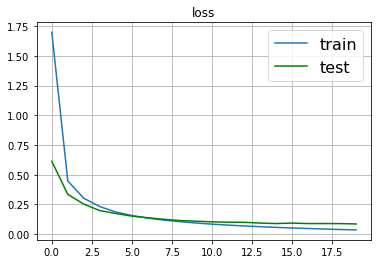

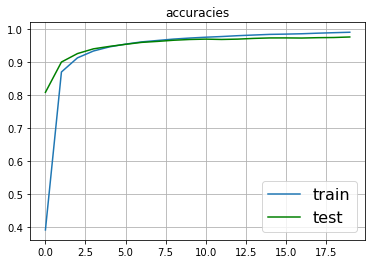

Final loss train is 0.03625918128943821,
Final loss test is 0.08645101227730335


In [23]:
train_relu_losses, test_relu_losses, train_relu_accuracies, test_relu_accuracies = fit(nn=nn, loss=loss, learning_rate=0.01, n_epoch=20, train_loader=train_loader, test_loader=test_loader)
print("Final loss train is {},\nFinal loss test is {}".format(train_relu_losses[-1], test_relu_losses[-1]))

In [24]:
layers = [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
nn = NeuralNetwork(layers)
loss = NLLLoss()

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

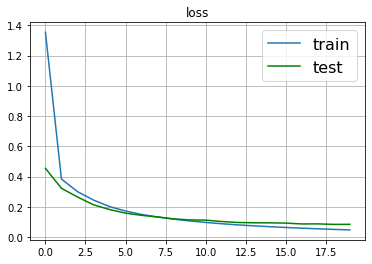

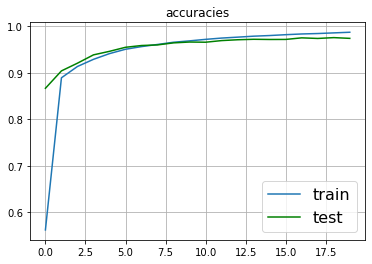

Final loss train is 0.04692965476403873,
Final loss test is 0.08378665335649928


In [25]:
train_elu_losses, test_elu_losses, train_elu_accuracies, test_elu_accuracies = fit(nn=nn, loss=loss, learning_rate=0.01, n_epoch=20, train_loader=train_loader, test_loader=test_loader)
print("Final loss train is {},\nFinal loss test is {}".format(train_elu_losses[-1], test_elu_losses[-1]))

### Сравнение функций активации

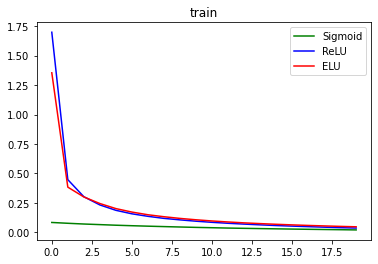

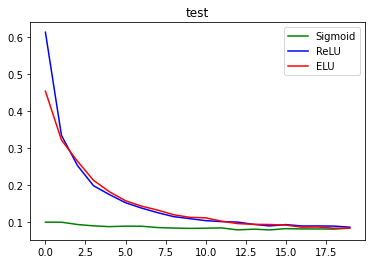

In [29]:
plt.plot(train_sigmoid_losses, color='g', label='Sigmoid')
plt.plot(train_relu_losses, color='b', label='ReLU')
plt.plot(train_elu_losses, color='r', label='ELU')
plt.title("train")
plt.legend(loc=0, fontsize=10)
plt.show()
plt.plot(test_sigmoid_losses, color='g', label='Sigmoid')
plt.plot(test_relu_losses, color='b', label='ReLU')
plt.plot(test_elu_losses, color='r', label='ELU')
plt.title("test")
plt.legend(loc=0, fontsize=10)
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [45]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = nn.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

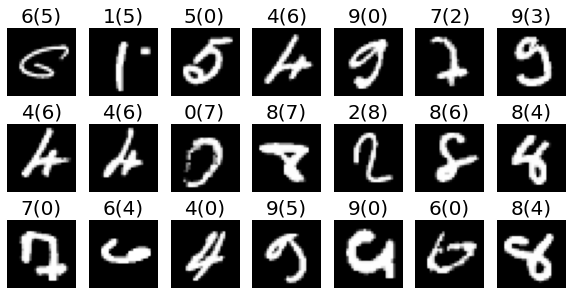

In [46]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [26]:
class Tanh:
    def __init__(self):
        self.tanh_f = lambda x : (np.exp(2 * x) - 1) / (np.exp(2 * x) + 1)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.y = self.tanh_f(X)
        self.X = X
        return self.y

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdx = dLdy * (1 - self.tanh_f(self.X) ** 2)
        return self.dLdx

    def step(self, learning_rate=0):
        pass

In [27]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)
loss = NLLLoss()

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

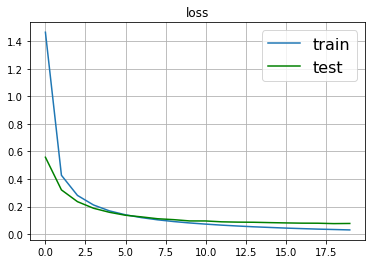

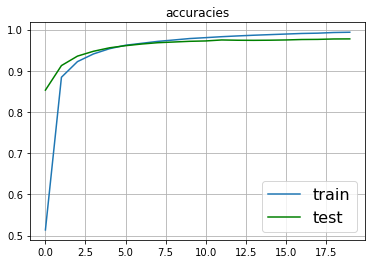

Final loss train is 0.03031996088945904,
Final loss test is 0.07719844632484855


In [28]:
final_loss = fit(nn=nn, loss=loss, learning_rate=0.01, n_epoch=20, train_loader=train_loader, test_loader=test_loader)
print("Final loss train is {},\nFinal loss test is {}".format(final_loss[0][-1], final_loss[1][-1]))

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [30]:
from torch import randn as torch_randn
from skimage.transform import rotate
from torch import tensor

In [31]:
class AddGaussianNoise(object):
    def __init__(self):
        pass

    def __call__(self, tensor):
        random_num = np.random.uniform(0.5, 1.1)
        return tensor + (0.1**random_num) * torch_randn(tensor.size())

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [32]:
def my_segmentation_transforms(image):
    #print(image.shape)
    X = image.view(image.shape[0], 28, 28).numpy()
    rotate_img = rotate(X[0].reshape(28,28), np.random.randint(-15, 15), mode="edge")
    rotate_img = rotate_img.reshape(1,28,28)
    #print(rotate_img.shape)
    image = tensor(rotate_img)
    return image

In [33]:
def pad_transform(image):
    constant_value=-0.42421296
    vector = image.view(image.shape[0], 28, 28).numpy().reshape(28,28)
    vect_shape = vector.shape[:2]
    #print(vect_shape)
    mode = np.random.randint(0,5)
    depth = np.random.randint(0, 5)
    if mode == 0: #top
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(pp, vector))[:28]
    elif mode == 1: #down
        pp = np.full(shape=(depth, vect_shape[1]), fill_value=constant_value)
        pv = np.vstack(tup=(vector, pp))[depth:]
    elif mode == 2: #left
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(pp, vector))[:, :28]
    elif mode == 3: #right
        pp = np.full(shape=(vect_shape[0], depth), fill_value=constant_value)
        pv = np.hstack(tup=(vector, pp))[:, depth:]
    else:
        return image
    #print(pv.reshape(1,28,28))

    return tensor(pv.reshape(1,28,28))

In [34]:
transform_noise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise()
])

transform_seg = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    my_segmentation_transforms
])

transform_rotate = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    pad_transform
])

In [35]:
train_dataset_noise = MNIST('.', train=True, download=True, transform=transform_noise)
test_dataset_noise = MNIST('.', train=False, transform=transform_noise)

train_dataset_seg = MNIST('.', train=True, download=True, transform=transform_seg)
test_dataset_seg = MNIST('.', train=False, transform=transform_seg)

train_dataset_pad = MNIST('.', train=True, download=True, transform=transform_rotate)
test_dataset_pad = MNIST('.', train=False, transform=transform_rotate)


train_loader_noise = DataLoader(train_dataset_noise, batch_size=32, shuffle=True)
test_loader_noise = DataLoader(test_dataset_noise, batch_size=32, shuffle=True)

train_loader_seg = DataLoader(train_dataset_seg, batch_size=32, shuffle=True)
test_loader_seg = DataLoader(test_dataset_seg, batch_size=32, shuffle=True)

train_loader_pad = DataLoader(train_dataset_pad, batch_size=32, shuffle=True)
test_loader_pad = DataLoader(test_dataset_pad, batch_size=32, shuffle=True)

(-0.5, 27.5, 27.5, -0.5)

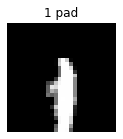

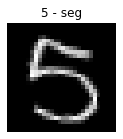

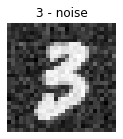

In [39]:
X_pad, y_pad = next(iter(train_loader_pad))
X_pad = X_pad.view(X_pad.shape[0], -1)
X_pad = X_pad.numpy()  ### Converts torch.Tensor to numpy array
y_pad = y_pad.numpy()

plt.figure(figsize=(2, 2))
plt.imshow(X_pad[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(f'{y_pad[0]} pad')
plt.axis('off')

X_seg, y_seg = next(iter(train_loader_seg))
X_seg = X_seg.view(X_seg.shape[0], -1)
X_seg = X_seg.numpy()  ### Converts torch.Tensor to numpy array
y_seg = y_seg.numpy()

plt.figure(figsize=(2, 2))
plt.imshow(X_seg[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(f'{y_seg[0]} - seg')
plt.axis('off')

X_noise, y_noise = next(iter(train_loader_noise))
X_noise = X_noise.view(X_noise.shape[0], -1)
X_noise = X_noise.numpy()  ### Converts torch.Tensor to numpy array
y_noise = y_noise.numpy()

plt.figure(figsize=(2, 2))
plt.imshow(X_noise[0].reshape(28, 28), cmap=plt.cm.Greys_r)
plt.title(f'{y_noise[0]} - noise')
plt.axis('off')

### Обучение

In [40]:
layers_sigmoid = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn_sigmoid = NeuralNetwork(layers_sigmoid)
loss = NLLLoss()

In [42]:
noise_train_losses, noise_test_losses, _, _  = fit(nn=nn_sigmoid, loss=loss, train_loader=train_loader_noise, test_loader=test_loader_noise, plot=False, n_epoch=20)
seg_train_losses, seg_test_losses, _, _ = fit(nn=nn_sigmoid, loss=loss, train_loader=train_loader_seg, test_loader=test_loader_seg, plot=False, n_epoch=20)
pad_train_losses, pad_test_losses , _, _= fit(nn=nn_sigmoid, loss=loss, train_loader=train_loader_pad, test_loader=test_loader_pad, plot=False, n_epoch=20)

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [43]:
transform_full = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(),
    my_segmentation_transforms,
    pad_transform
])

train_dataset_full = MNIST('.', train=True, download=True, transform=transform_full)
test_dataset_full = MNIST('.', train=False, transform=transform_full)

train_loader_full = DataLoader(train_dataset_full, batch_size=32, shuffle=True)
test_loader_full = DataLoader(test_dataset_full, batch_size=32, shuffle=True)
full_train_losses, full_test_losses, _, _ = fit(nn=nn_sigmoid, loss=loss, train_loader=train_loader_full, test_loader=test_loader_full, plot=False, n_epoch=20)

/var/folders/04/7ltt_n9d1z14zmw8_ky4jc5h0000gn/T/ipykernel_15561/324477467.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(n_epoch)):


  0%|          | 0/20 [00:00<?, ?it/s]

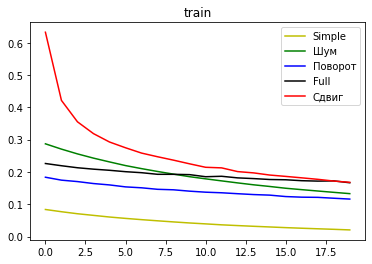

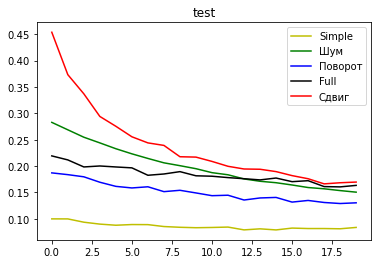

In [44]:
plt.plot(train_sigmoid_losses, color='y', label='Simple')
plt.plot(noise_train_losses, color='g', label='Шум')
plt.plot(seg_train_losses, color='b', label='Поворот')
plt.plot(full_train_losses, color='k', label='Full')
plt.plot(pad_train_losses, color='r', label='Сдвиг')
plt.title("train")
plt.legend(loc=0, fontsize=10)
plt.show()
plt.plot(test_sigmoid_losses, color='y', label='Simple')
plt.plot(noise_test_losses, color='g', label='Шум')
plt.plot(seg_test_losses, color='b', label='Поворот')
plt.plot(full_test_losses, color='k', label='Full')
plt.plot(pad_test_losses, color='r', label='Сдвиг')
plt.legend(loc=0, fontsize=10)
plt.title("test")
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Как видно из графиков выше нелинейности Relu и ELU повели себя лучше, от этого могу предположить что именно они лучше себя ведут на задачах распознавания изображений.

Аугментация это полезный инструмент, который позволяет искуственно увеличить выборку изображений и ускоряет сходимость